# Time Series Analysis Framework for additive models

Dataset: Natural Gaz comsuption in the US since the 1990s
https://www.eia.gov/totalenergy/data/browser/index.php?tbl=T01.03#/?f=M&start=200001&end=202406&charted=2

## I) Time Series Analysis

#### Import data

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import f_oneway, linregress
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

In [140]:
df = pd.read_csv("MER_T01_03.csv")
df.head()

,MSN,YYYYMM,Value,Column_Order,Description,Unit
0,CLTCBUS,194913,11.980905,1,Coal Consumption,Quadrillion Btu
1,CLTCBUS,195013,12.347109,1,Coal Consumption,Quadrillion Btu
2,CLTCBUS,195113,12.552996,1,Coal Consumption,Quadrillion Btu
3,CLTCBUS,195213,11.306479,1,Coal Consumption,Quadrillion Btu
4,CLTCBUS,195313,11.372684,1,Coal Consumption,Quadrillion Btu


The data we have chosen for analysis represent the primary energy consumption by source over the years, highlighting trends in the usage of fossil fuels, renewable energy, and nuclear power, and offering insights into how the global energy mix has shifted in the years.

#### Data Cleaning

In our case, we will focus on the consumption of natural gas between 1990 and 2024, using monthly data to analyze seasonal patterns, long-term trends, and any significant fluctuations that may correspond with economic, policy, or environmental events.

In [141]:
filtered_df = df[df['Description'] == 'Natural Gas Consumption (Excluding Supplemental Gaseous Fuels)']
filtered_df = filtered_df[['YYYYMM', 'Value']]
filtered_df['Value'] = filtered_df['Value'].astype('float')
filtered_df = filtered_df[filtered_df['YYYYMM'] % 100 != 13]
filtered_df['Date'] = pd.to_datetime(filtered_df['YYYYMM'].astype(str), format='%Y%m')
filtered_df = filtered_df.drop(columns =['YYYYMM'])
filtered_df.head()

,Value,Date
717,2.397308,1973-01-01
718,2.170646,1973-02-01
719,2.057315,1973-03-01
720,1.873535,1973-04-01
721,1.765309,1973-05-01


In [142]:
data = filtered_df[(filtered_df['Date'] >= '1990-01-01') & (filtered_df['Date'] < '2024-01-01')]
data.head()

,Value,Date
938,2.214586,1990-01-01
939,1.907248,1990-02-01
940,1.870650,1990-03-01
941,1.668133,1990-04-01
942,1.452612,1990-05-01


#### Visualize the Time Series

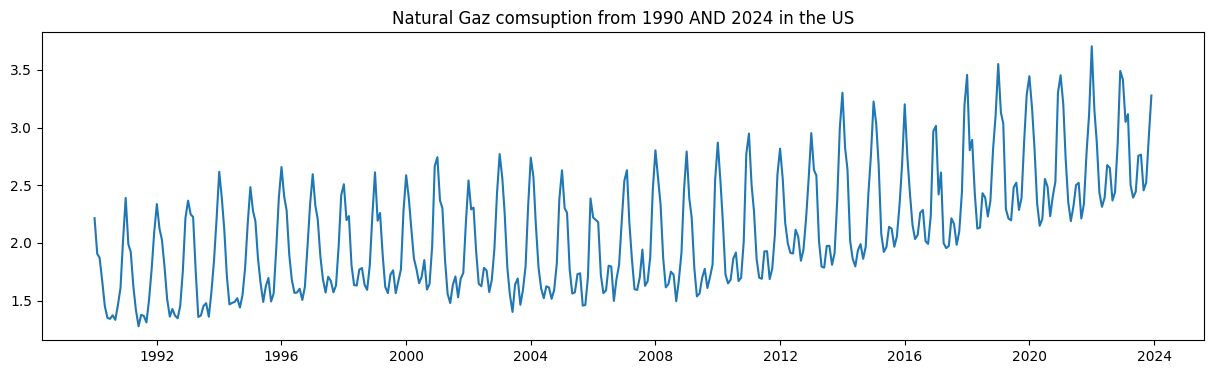

In [143]:
plt.figure(figsize=(15,4))
plt.plot(data['Date'], data['Value'])
plt.title('Natural Gaz comsuption from 1990 AND 2024 in the US')

plt.show()

It can be observed that this appears to be a monthly time series with a recurring pattern each year. The annual peaks can be interpreted as increases in consumption during winter months, likely reflecting heightened demand for heating.

## II) ETS Decomposition

### 1- Additive or Multiplicative Time Series ?


We may have different combinations of trends and seasonality. Depending on the nature of the trends and seasonality, a time series can be modeled as an additive or multiplicative time series. Each observation in the series can be expressed as either a sum or a product of the components.


- Additive time series:

        Value = Base Level + Trend + Seasonality + Error

- Multiplicative Time Series:

        Value = Base Level x Trend x Seasonality x Error


Let's construct a BB table to see the relation ship between the mean and standar deviation. And then check the type of combination. 


In [144]:
data.loc[:, 'year'] = data['Date'].dt.year
data.loc[:, 'month'] = data['Date'].dt.month
bb_table = data.pivot(index="year", columns="month", values='Value')
bb_table.round(2)

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/2606275020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'year'] = data['Date'].dt.year
/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/2606275020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:, 'month'] = data['Date'].dt.month


month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1990,2.21,1.91,1.87,1.67,1.45,1.35,1.34,1.37,1.33,1.46,1.61,2.02
1991,2.39,1.99,1.92,1.62,1.42,1.28,1.38,1.37,1.31,1.50,1.77,2.09
1992,2.34,2.12,2.02,1.78,1.51,1.36,1.43,1.37,1.35,1.45,1.76,2.21
1993,2.37,2.25,2.22,1.75,1.36,1.37,1.45,1.48,1.36,1.57,1.84,2.21
1994,2.62,2.38,2.12,1.71,1.47,1.48,1.49,1.52,1.44,1.55,1.79,2.17
1995,2.48,2.28,2.19,1.86,1.65,1.49,1.62,1.70,1.49,1.56,1.96,2.39
1996,2.66,2.40,2.28,1.90,1.68,1.57,1.57,1.60,1.51,1.62,1.97,2.33
1997,2.60,2.32,2.20,1.88,1.68,1.57,1.71,1.67,1.57,1.63,1.97,2.41
1998,2.51,2.20,2.23,1.80,1.63,1.63,1.77,1.78,1.64,1.59,1.81,2.23


In [145]:
# Compute the column-wise mean and standard deviation
column_means = bb_table.mean(numeric_only=True, axis=0)
column_stds = bb_table.std(numeric_only=True, axis=0)

# Add these as rows to the Buys-Ballot table
bb_table.loc['MEAN'] = column_means
bb_table.loc['STD'] = column_stds


bb_table["MEAN"] = bb_table.mean(numeric_only=True, axis=1)
bb_table["STD"] = bb_table.std(numeric_only=True, axis=1)

bb_table.round(2)

month,1,2,3,4,5,6,7,8,9,10,11,12,MEAN,STD
year,,,,,,,,,,,,,,
1990,2.21,1.91,1.87,1.67,1.45,1.35,1.34,1.37,1.33,1.46,1.61,2.02,1.63,0.29
1991,2.39,1.99,1.92,1.62,1.42,1.28,1.38,1.37,1.31,1.50,1.77,2.09,1.67,0.34
1992,2.34,2.12,2.02,1.78,1.51,1.36,1.43,1.37,1.35,1.45,1.76,2.21,1.73,0.35
1993,2.37,2.25,2.22,1.75,1.36,1.37,1.45,1.48,1.36,1.57,1.84,2.21,1.77,0.38
1994,2.62,2.38,2.12,1.71,1.47,1.48,1.49,1.52,1.44,1.55,1.79,2.17,1.81,0.39
1995,2.48,2.28,2.19,1.86,1.65,1.49,1.62,1.70,1.49,1.56,1.96,2.39,1.89,0.35
1996,2.66,2.40,2.28,1.90,1.68,1.57,1.57,1.60,1.51,1.62,1.97,2.33,1.92,0.38
1997,2.60,2.32,2.20,1.88,1.68,1.57,1.71,1.67,1.57,1.63,1.97,2.41,1.94,0.35
1998,2.51,2.20,2.23,1.80,1.63,1.63,1.77,1.78,1.64,1.59,1.81,2.23,1.90,0.29



The bb_table displays monthly consumption values by year, allowing us to observe seasonal trends (mean) and month-to-month variability (standard deviation). This helps identify annual patterns and monthly fluctuations.

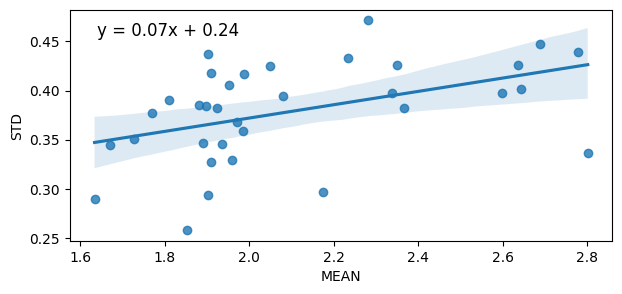

In [146]:
# Data (assuming annual_means and annual_SD are already defined)
annual_means = bb_table["MEAN"].iloc[:-2]
annual_SD = bb_table["STD"].iloc[:-2]

# Calculate the regression coefficients
slope, intercept, r_value, p_value, std_err = linregress(annual_means, annual_SD)

# Plot using sns.regplot
sns.regplot(x=annual_means, y=annual_SD)

# Annotate the plot with the regression equation
plt.text(
    0.05, 0.95,  # Position (adjust as necessary)
    f'y = {slope:.2f}x + {intercept:.2f}',  # Format the equation as needed
    transform=plt.gca().transAxes,  # Use Axes coordinates (0,0 lower left to 1,1 upper right)
    fontsize=12,
    verticalalignment='top'
)

# Display the plot
plt.show()


Conclusion: the model is additive as the coefficient a is almost 0, indicating that the seasonal variations remain constant in amplitude over time rather than growing or shrinking with the trend.

### 2- Detrend the data - Remove the Pseudo-Trend

In time series analysis, it’s typically necessary to detrend before deseasonalizing a series because:

- It allow us to isolate the seasonality pattern more accurately (as seasonality may interact with trends), making the seasonal component harder to detect when a trend is present. Doing so result in a cleaner, more stable extraction of seasonality, facilitating accurate modeling and interpretation.

**However, we need to get the seasonality to get the best trend possible that why we will extract a pseudo trend first.**

#### 2.1- CMA


To do that, we will perform a Centered Moving Average (CMA), which smooths the time series by averaging values around each point. This process helps in extracting the underlying trend by reducing short-term fluctuations, making it easier to identify the core seasonal pattern.

In [147]:
window_size=12
data['pseudo trend'] = data['Value'].rolling(window=window_size, center=True).mean()
data.head(20)

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/1671207598.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pseudo trend'] = data['Value'].rolling(window=window_size, center=True).mean()


,Value,Date,year,month,pseudo trend
938,2.214586,1990-01-01,1990,1,NaN
939,1.907248,1990-02-01,1990,2,NaN
940,1.870650,1990-03-01,1990,3,NaN
941,1.668133,1990-04-01,1990,4,NaN
942,1.452612,1990-05-01,1990,5,NaN
943,1.350899,1990-06-01,1990,6,NaN
944,1.341798,1990-07-01,1990,7,1.633606
945,1.372602,1990-08-01,1990,8,1.648163
946,1.333192,1990-09-01,1990,9,1.654875
947,1.458073,1990-10-01,1990,10,1.659115


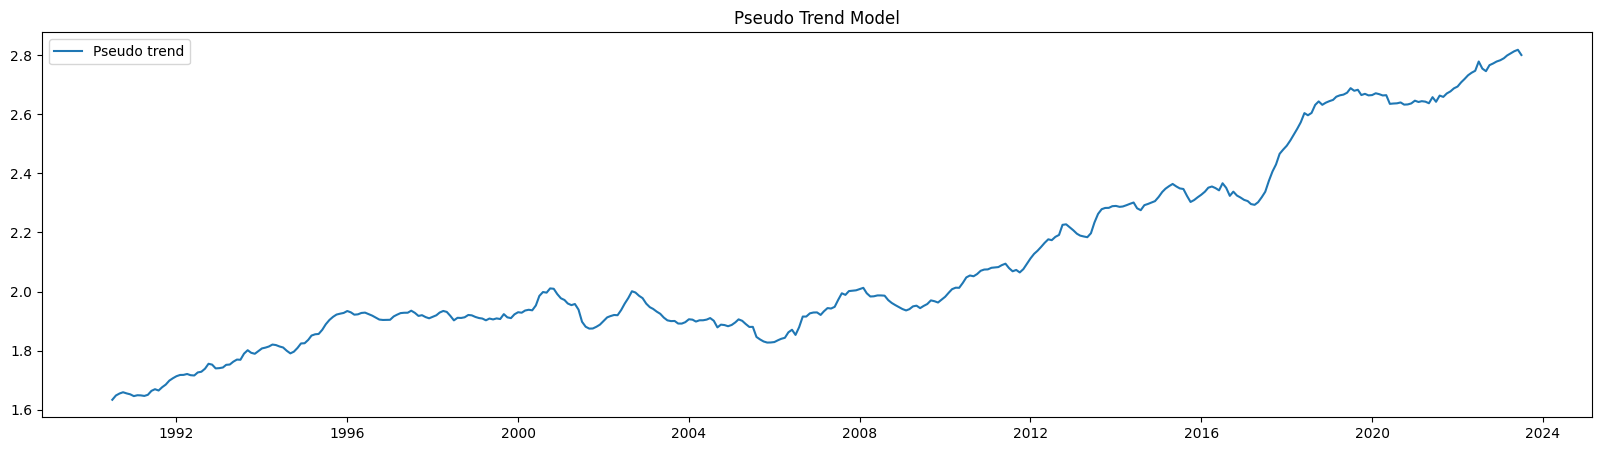

In [148]:
plt.figure(figsize=(20,5))
plt.plot('Date', 'pseudo trend', data=data, label='Pseudo trend')
plt.legend()
plt.title('Pseudo Trend Model')
plt.show()

#### 2.2- Detrend the Pseudo Trend on original values


Once we have the pseudo trend, given that the series components are additive, we can subtract the trend to observe the values with and without the trend component. This subtraction isolates the seasonality and residuals, allowing us to analyze the underlying seasonal patterns independently of the long-term trend.

In [149]:
data['pseudo detrend value'] = data['Value']-data['pseudo trend']

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/438604046.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pseudo detrend value'] = data['Value']-data['pseudo trend']


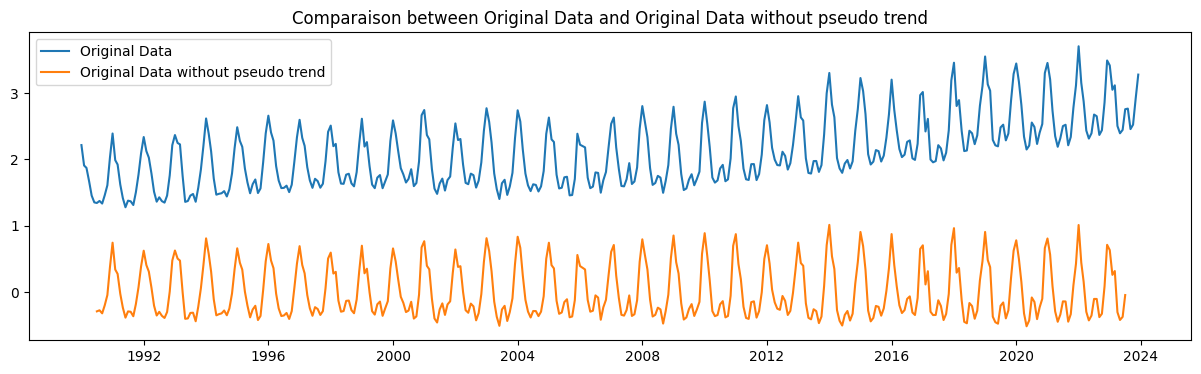

In [150]:
plt.figure(figsize=(15,4))
plt.plot(data['Date'], data['Value'], label='Original Data')
plt.plot(data['Date'], data['pseudo detrend value'], label='Original Data without pseudo trend')
plt.title('Comparaison between Original Data and Original Data without pseudo trend')
plt.legend()
plt.show()

### 3- Remove the Seasonality

Now that we have the series without the trend, we need to extract the seasonality.

Isolating the seasonal component helps us identify patterns that repeat over time, which can be crucial for forecasting and making informed decisions based on historical data. 

#### 3.1- Check the existance of seasonality 

Nevertheless, it is essential to first verify the existence of seasonality through an ANOVA test. In our case, we aim to identify an annual seasonality, which involves comparing the means of different groups—specifically, the monthly averages across multiple years.

In [151]:
bb_table_without_trend = data.pivot(index="year", columns="month", values='pseudo detrend value')
bb_table_without_trend.round(2)

month,1,2,3,4,5,6,7,8,9,10,11,12
year,,,,,,,,,,,,
1990,NaN,NaN,NaN,NaN,NaN,NaN,-0.29,-0.28,-0.32,-0.20,-0.05,0.37
1991,0.74,0.34,0.27,-0.03,-0.23,-0.39,-0.29,-0.30,-0.37,-0.18,0.07,0.38
1992,0.62,0.41,0.31,0.06,-0.21,-0.35,-0.30,-0.36,-0.39,-0.30,0.01,0.47
1993,0.63,0.50,0.47,-0.00,-0.40,-0.40,-0.32,-0.31,-0.44,-0.22,0.06,0.41
1994,0.81,0.57,0.31,-0.11,-0.35,-0.33,-0.32,-0.28,-0.35,-0.25,-0.02,0.34
1995,0.66,0.44,0.34,0.01,-0.21,-0.38,-0.26,-0.21,-0.42,-0.36,0.03,0.46
1996,0.72,0.48,0.36,-0.03,-0.25,-0.36,-0.35,-0.32,-0.41,-0.29,0.07,0.43
1997,0.69,0.41,0.28,-0.05,-0.24,-0.36,-0.23,-0.26,-0.35,-0.29,0.06,0.50
1998,0.59,0.28,0.30,-0.13,-0.30,-0.29,-0.13,-0.13,-0.27,-0.32,-0.11,0.32


In [152]:
season = [bb_table_without_trend[col] for col in bb_table_without_trend.columns]
season

[year
 1990         NaN
 1991    0.743247
 1992    0.622862
 1993    0.625187
 1994    0.808429
 1995    0.658314
 1996    0.723384
 1997    0.691037
 1998    0.593750
 1999    0.697680
 2000    0.656505
 2001    0.765671
 2002    0.640926
 2003    0.810724
 2004    0.832614
 2005    0.742577
 2006    0.391135
 2007    0.605789
 2008    0.793755
 2009    0.851400
 2010    0.886702
 2011    0.872118
 2012    0.704817
 2013    0.744261
 2014    1.011774
 2015    0.904831
 2016    0.873051
 2017    0.703863
 2018    0.962245
 2019    0.905280
 2020    0.779320
 2021    0.806636
 2022    1.009796
 2023    0.631977
 Name: 1, dtype: float64,
 year
 1990         NaN
 1991    0.338816
 1992    0.406147
 1993    0.503812
 1994    0.574294
 1995    0.441248
 1996    0.475271
 1997    0.407321
 1998    0.278219
 1999    0.281888
 2000    0.462341
 2001    0.395150
 2002    0.377964
 2003    0.617289
 2004    0.665276
 2005    0.404889
 2006    0.363354
 2007    0.708713
 2008    0.552749
 2009   

If the ANOVA test indicates significant differences between these means, it suggests that seasonality is present in the data. This statistical verification is crucial because it confirms that any observed fluctuations are not due to random variation but rather to consistent seasonal patterns that recur annually.

In [153]:
# Perform ANOVA test
f_stat, p_value = f_oneway(*[bb_table_without_trend[col].dropna() for col in bb_table_without_trend.columns])

print("f_stat :", f_stat, "\np_value :", p_value)

f_stat : 532.2315113107394 
p_value : 3.973641162337089e-225


Conclusion

Seasonality has been identified! Since the p-values are less than 0.05, we reject the null hypothesis, indicating that there is a significant seasonal effect present in the data. This means that the variations in the time series are not just random fluctuations but are influenced by consistent seasonal patterns that occur at specific intervals. 

#### 3.2- Area conservation principle for additive model

Now that we are confident in the presence of seasonality, we must ensure that the principle of area conservation is respected. This principle states that when we deseasonalize a time series, the total area (or sum in our case) of the seasonal component should remain consistent before and after the adjustment. 

To achieve this, we calculate the necessary correction by assessing the sum of the seasonal factors and comparing it to the overall average of the time series. By adjusting (shifting) the seasonal values accordingly, we ensure that the modifications do not distort the data’s overall balance, maintaining the integrity of the time series analysis.

In [154]:
# Compute the column-wise mean and standard deviation
column_means = bb_table_without_trend.mean(numeric_only=True, axis=0)
column_stds = bb_table_without_trend.std(numeric_only=True, axis=0)

# Add these as rows to the Buys-Ballot table
bb_table_without_trend.loc['MEAN'] = column_means
bb_table_without_trend.loc['STD'] = column_stds

bb_table_without_trend["MEAN"] = bb_table_without_trend.mean(numeric_only=True, axis=1)
bb_table_without_trend["STD"] = bb_table_without_trend.std(numeric_only=True, axis=1)


In [155]:
shift = np.mean(bb_table_without_trend.loc["MEAN"][:-2])
correction = bb_table_without_trend.loc["MEAN"][:-2]-shift
np.sum(correction)

1.6653345369377348e-16

In [156]:
bb_table_without_trend.loc['Adjusted seasonal coef'] = correction
bb_table_without_trend.round(2)

month,1,2,3,4,5,6,7,8,9,10,11,12,MEAN,STD
year,,,,,,,,,,,,,,
1990,NaN,NaN,NaN,NaN,NaN,NaN,-0.29,-0.28,-0.32,-0.20,-0.05,0.37,-0.13,0.24
1991,0.74,0.34,0.27,-0.03,-0.23,-0.39,-0.29,-0.30,-0.37,-0.18,0.07,0.38,0.00,0.35
1992,0.62,0.41,0.31,0.06,-0.21,-0.35,-0.30,-0.36,-0.39,-0.30,0.01,0.47,-0.00,0.35
1993,0.63,0.50,0.47,-0.00,-0.40,-0.40,-0.32,-0.31,-0.44,-0.22,0.06,0.41,-0.00,0.39
1994,0.81,0.57,0.31,-0.11,-0.35,-0.33,-0.32,-0.28,-0.35,-0.25,-0.02,0.34,0.00,0.39
1995,0.66,0.44,0.34,0.01,-0.21,-0.38,-0.26,-0.21,-0.42,-0.36,0.03,0.46,0.01,0.36
1996,0.72,0.48,0.36,-0.03,-0.25,-0.36,-0.35,-0.32,-0.41,-0.29,0.07,0.43,0.00,0.38
1997,0.69,0.41,0.28,-0.05,-0.24,-0.36,-0.23,-0.26,-0.35,-0.29,0.06,0.50,0.01,0.35
1998,0.59,0.28,0.30,-0.13,-0.30,-0.29,-0.13,-0.13,-0.27,-0.32,-0.11,0.32,-0.02,0.29


In [157]:
data['Seasonal Index'] = data['month'].map(correction)
data.head(15)

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/510019346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Seasonal Index'] = data['month'].map(correction)


,Value,Date,year,month,pseudo trend,pseudo detrend value,Seasonal Index
938,2.214586,1990-01-01,1990,1,NaN,NaN,0.758229
939,1.907248,1990-02-01,1990,2,NaN,NaN,0.448012
940,1.870650,1990-03-01,1990,3,NaN,NaN,0.282951
941,1.668133,1990-04-01,1990,4,NaN,NaN,-0.150717
942,1.452612,1990-05-01,1990,5,NaN,NaN,-0.346266
943,1.350899,1990-06-01,1990,6,NaN,NaN,-0.371777
944,1.341798,1990-07-01,1990,7,1.633606,-0.291808,-0.210145
945,1.372602,1990-08-01,1990,8,1.648163,-0.275561,-0.199491
946,1.333192,1990-09-01,1990,9,1.654875,-0.321683,-0.388389
947,1.458073,1990-10-01,1990,10,1.659115,-0.201042,-0.292673


Like this, we can identify the pattern of the season, which reveals how consumption behaves during specific times of the year.

#### 3.3- Remove the Seasonality on original values

Once we have the seasonal component, given that the series components are additive, we can subtract the seasonal effects to observe the values with and without seasonality. This subtraction isolates the trend and residuals, enabling us to analyze the underlying trend patterns independently of seasonal fluctuations.

In [158]:
data['Value without seasonality'] = data['Value'] - data['Seasonal Index']
data.head()

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/264368217.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Value without seasonality'] = data['Value'] - data['Seasonal Index']


,Value,Date,year,month,pseudo trend,pseudo detrend value,Seasonal Index,Value without seasonality
938,2.214586,1990-01-01,1990,1,NaN,NaN,0.758229,1.456357
939,1.907248,1990-02-01,1990,2,NaN,NaN,0.448012,1.459236
940,1.870650,1990-03-01,1990,3,NaN,NaN,0.282951,1.587699
941,1.668133,1990-04-01,1990,4,NaN,NaN,-0.150717,1.818850
942,1.452612,1990-05-01,1990,5,NaN,NaN,-0.346266,1.798878


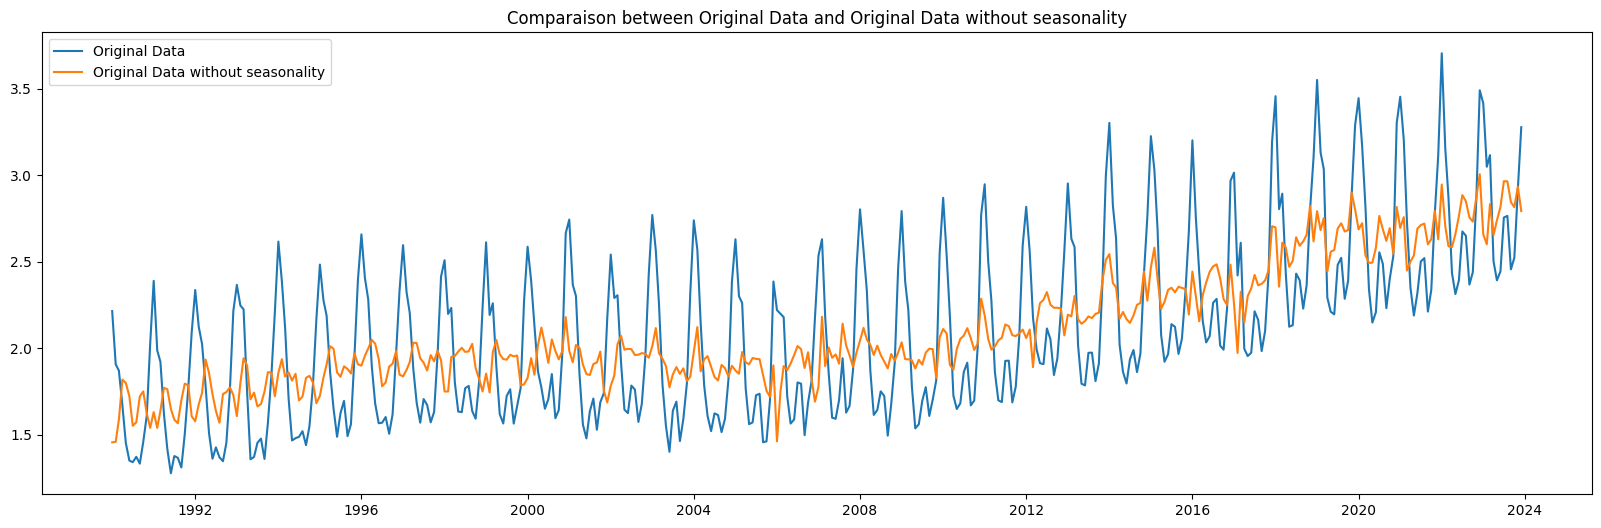

In [159]:
plt.figure(figsize=(20,6))
plt.plot('Date', 'Value', data=data, label='Original Data')
plt.plot('Date', 'Value without seasonality', data=data , label='Original Data without seasonality')
plt.legend()
plt.title('Comparaison between Original Data and Original Data without seasonality')
plt.show()

### 4- Remove the real Trend

Now that we have removed the seasonality, we need to look for the real trend in order to identify the long-term direction of the data. 

This involves analyzing how the values change over time, which can reveal whether the overall trend is increasing, decreasing, or stable. 

#### 4.1- Find the trend

Since the data is neither linear nor linearizable, we will use a double exponential smoothing to capture the trend.

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


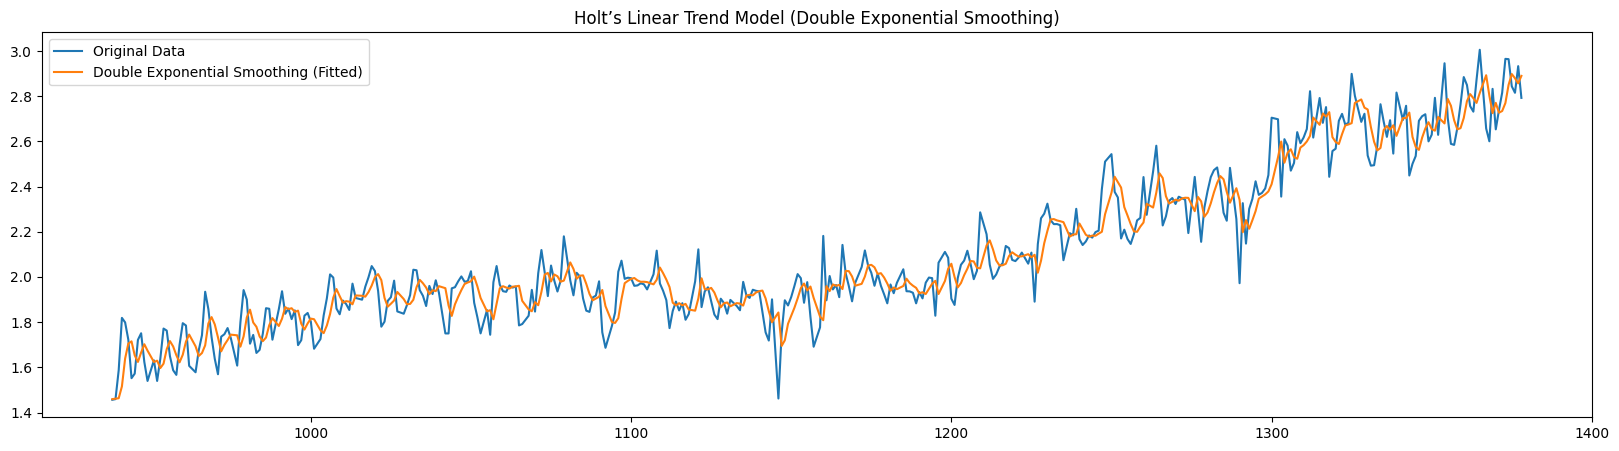

In [160]:
# Assuming your time series data is in the 'MEAN' column of bb_table_without_trend
time_series_data = data["Value without seasonality"]

# Create the Holt's linear trend model (Double Exponential Smoothing)
holt_model = Holt(time_series_data).fit(optimized=True)

# Get the fitted values (smoothed data)
fitted_values = holt_model.fittedvalues

# Plot the original data, fitted values, and forecasts
plt.figure(figsize=(20, 5))
plt.plot(time_series_data, label='Original Data')
plt.plot(fitted_values, label='Double Exponential Smoothing (Fitted)')
#plt.plot(forecasted_values, label='Forecast', linestyle='--', color='red')
plt.legend()
plt.title('Holt’s Linear Trend Model (Double Exponential Smoothing)')
plt.show()


#### 4.2 - Remove the Trend

Once we have the trend component, given that the series components are additive, we can subtract the trend effects to observe the values with and without the trend. This subtraction isolates residuals. This process is essential for understanding the overall dynamics of the data and for identifying any short-term fluctuations that may be obscured by the trend variations.

In [161]:
data["trend"] = fitted_values
data.head()

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/1128931163.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["trend"] = fitted_values


,Value,Date,year,month,pseudo trend,pseudo detrend value,Seasonal Index,Value without seasonality,trend
938,2.214586,1990-01-01,1990,1,NaN,NaN,0.758229,1.456357,1.459236
939,1.907248,1990-02-01,1990,2,NaN,NaN,0.448012,1.459236,1.460974
940,1.870650,1990-03-01,1990,3,NaN,NaN,0.282951,1.587699,1.463164
941,1.668133,1990-04-01,1990,4,NaN,NaN,-0.150717,1.818850,1.515428
942,1.452612,1990-05-01,1990,5,NaN,NaN,-0.346266,1.798878,1.638630


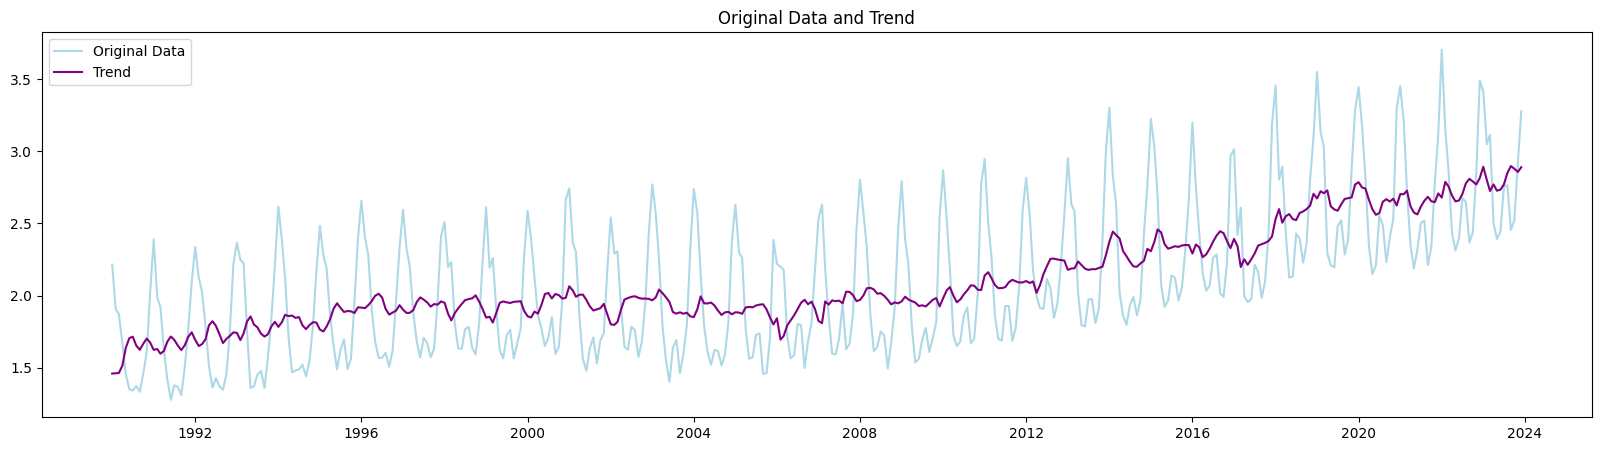

In [162]:
plt.figure(figsize=(20, 5))

# Original data
plt.plot(data['Date'], data['Value'], label='Original Data', color='lightblue')

# Trend data
plt.plot(data['Date'], data['trend'], label='Trend', color='purple')

plt.title('Original Data and Trend')
plt.legend() 
plt.show()

### 5- Residual

Now that we have removed the trend, we need to analyze the residuals to understand the short-term fluctuations in the data. Residuals represent the deviations from the expected values after accounting for both seasonality and the trend, capturing the random variations and noise inherent in the time series.

In [163]:
data["residual"] = data["Value without seasonality"] - data["trend"]

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/3037646969.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["residual"] = data["Value without seasonality"] - data["trend"]


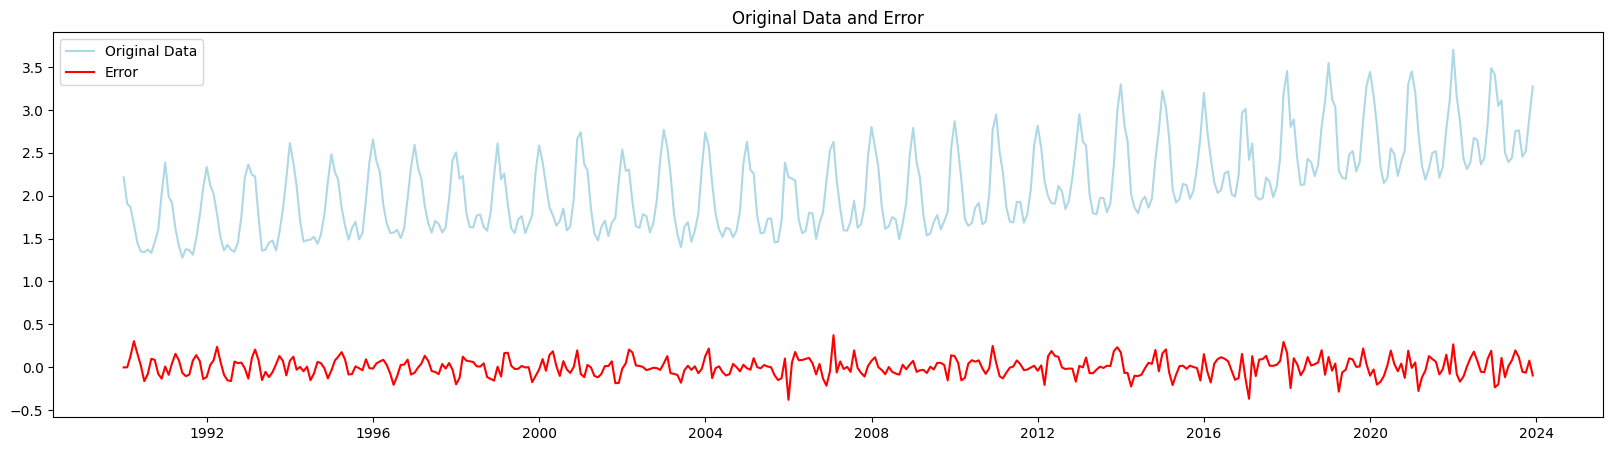

In [164]:
plt.figure(figsize=(20, 5))

# Original data
plt.plot(data['Date'], data['Value'], label='Original Data', color='lightblue')

# Error data
plt.plot(data['Date'], data['residual'], label='Error', color='red')

plt.title('Original Data and Error')
plt.legend() 
plt.show()

### 6- Final graph 

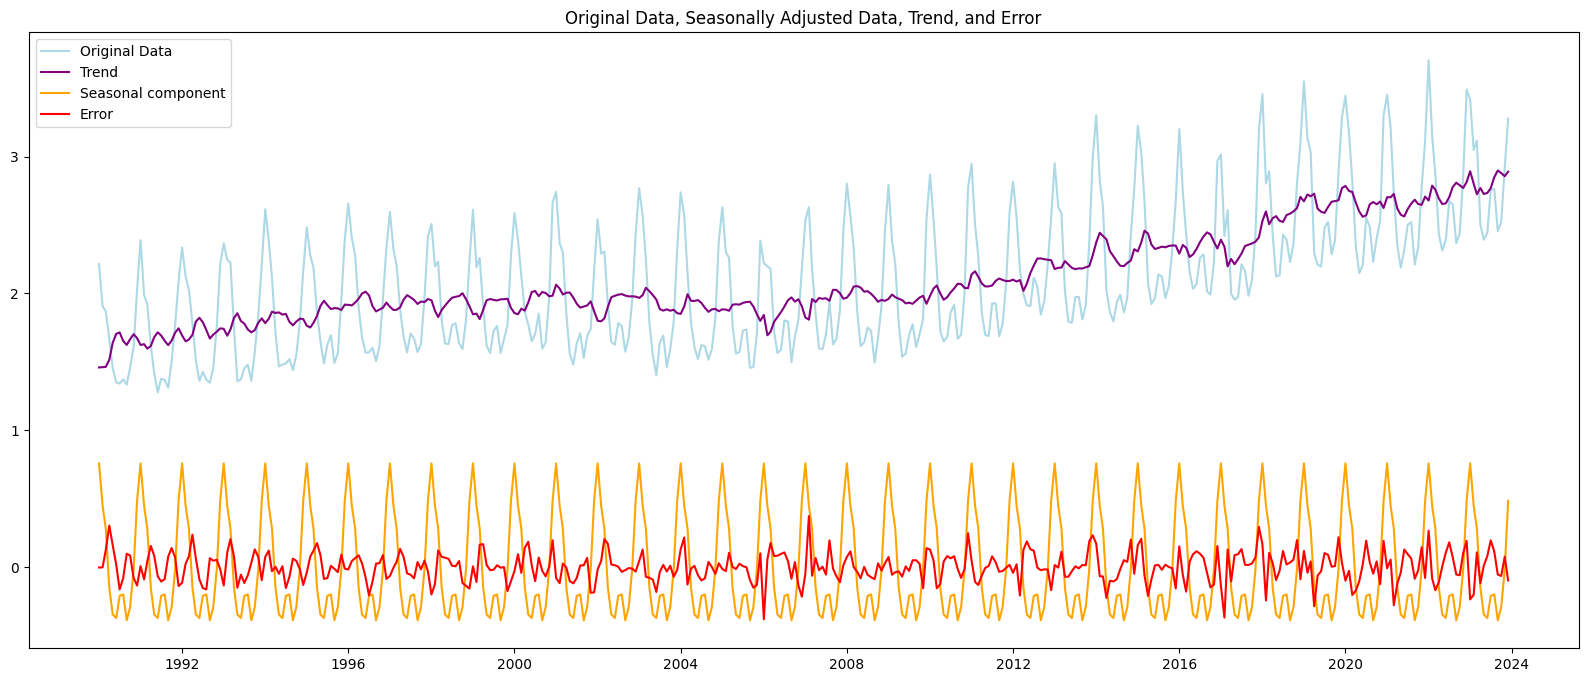

In [165]:
# Plot original, adjusted, trend, and error data
plt.figure(figsize=(20, 8))

# Original data
plt.plot(data['Date'], data['Value'], label='Original Data', color='lightblue')

# Trend data
plt.plot(data['Date'], data['trend'], label='Trend', color='purple')

# Seasonality
plt.plot(data['Date'], data['Seasonal Index'], label='Seasonal component', color='orange')

# Error data
plt.plot(data['Date'], data['residual'], label='Error', color='red')

# Add labels and title
""" plt.xlabel('Month')
plt.ylabel('Monthly Beer Production')"""
plt.title('Original Data, Seasonally Adjusted Data, Trend, and Error')
plt.legend() 

# Show the plot
plt.show()

## III) Comparison of our ETS process and the one from statsmodels package: seasonal_decompose

https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html#statsmodels-tsa-seasonal-seasonal-decompose

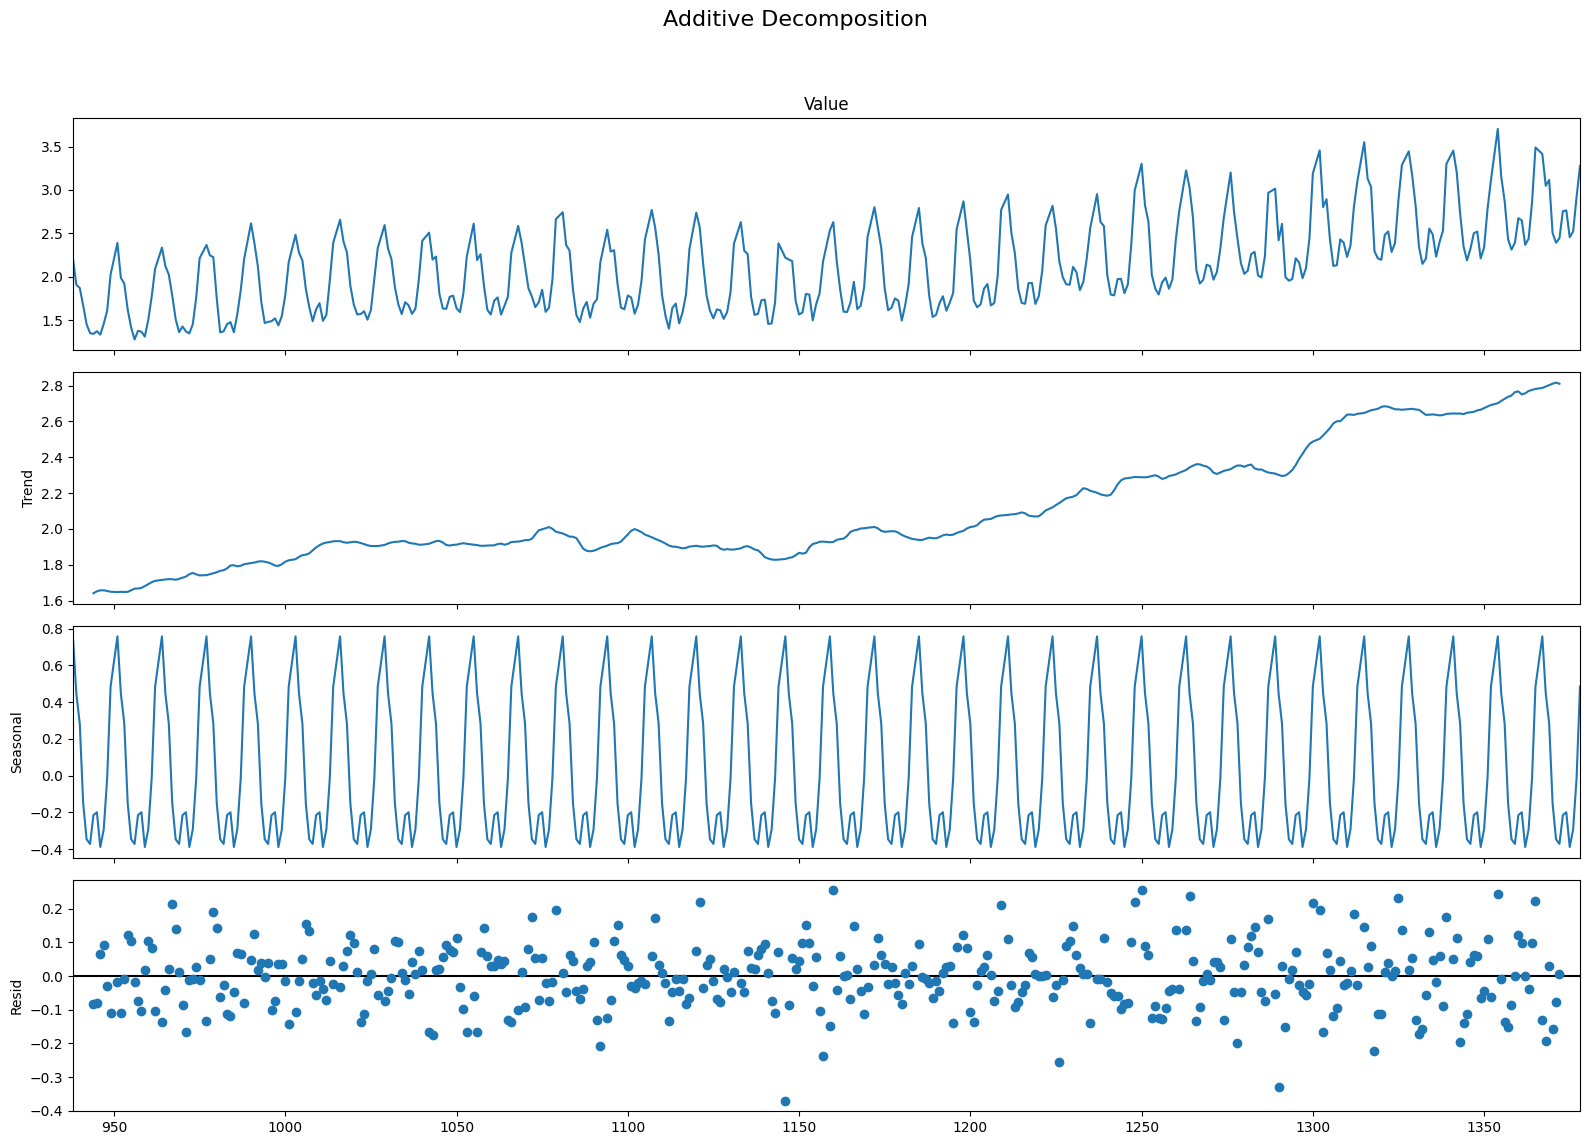

In [166]:
# Additive Decomposition
additive_decomposition = seasonal_decompose(data['Value'], model='additive', period=12)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/106342537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Stat model trend"] = additive_decomposition.trend


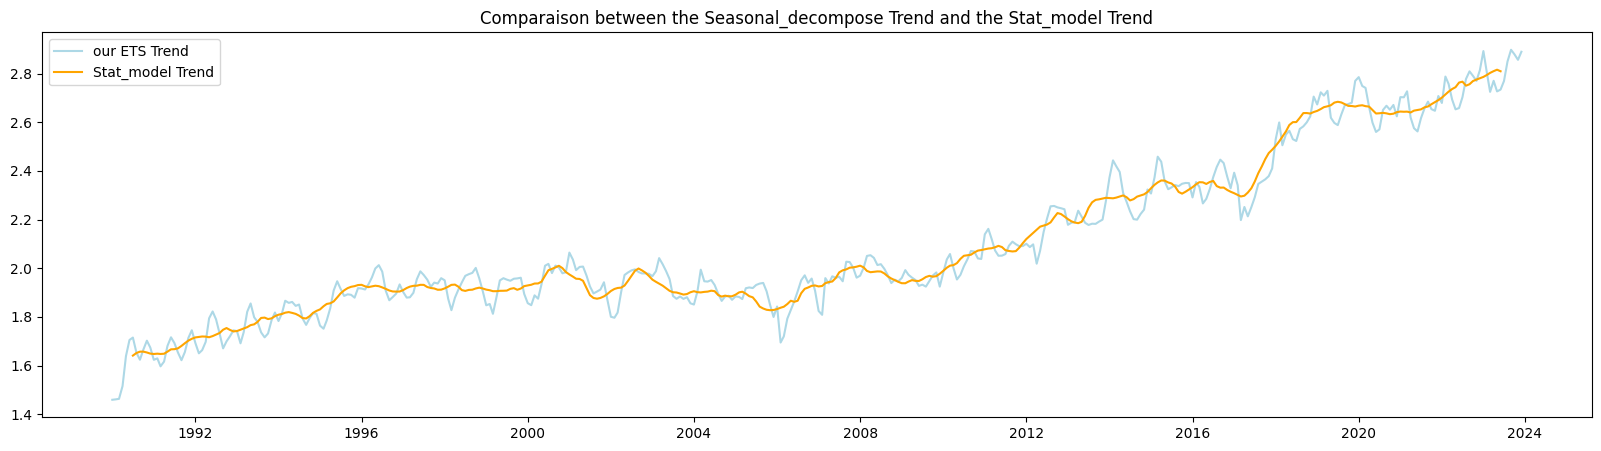

In [167]:
data["Stat model trend"] = additive_decomposition.trend

plt.figure(figsize=(20, 5))

# Original data
plt.plot(data['Date'], data['trend'], label='our ETS Trend', color='lightblue')
plt.plot(data['Date'], data['Stat model trend'], label='Stat_model Trend', color='orange')
plt.legend()
plt.title('Comparaison between the Seasonal_decompose Trend and the Stat_model Trend')
plt.show()


The discrepancies between the trend from statmodel package and our trend modeling come from the fact that Holt’s method focuses on forecasting, it automatically optimize the smoothing parameters (`smoothing_level`, `smoothing_slope`). This can lead to less smooth trends compared to seasonal_decompose, which uses a moving average for a smoother, long-term trend.

As our main concern is forecasting, it’s generally better to use Holt's Method. However we can still get closer from the trend that the package is giving us, if we want, by modifying manually the parameters:

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/995412814.py:4: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  ).fit(optimized=True, smoothing_level=0.1, smoothing_slope=0.1)


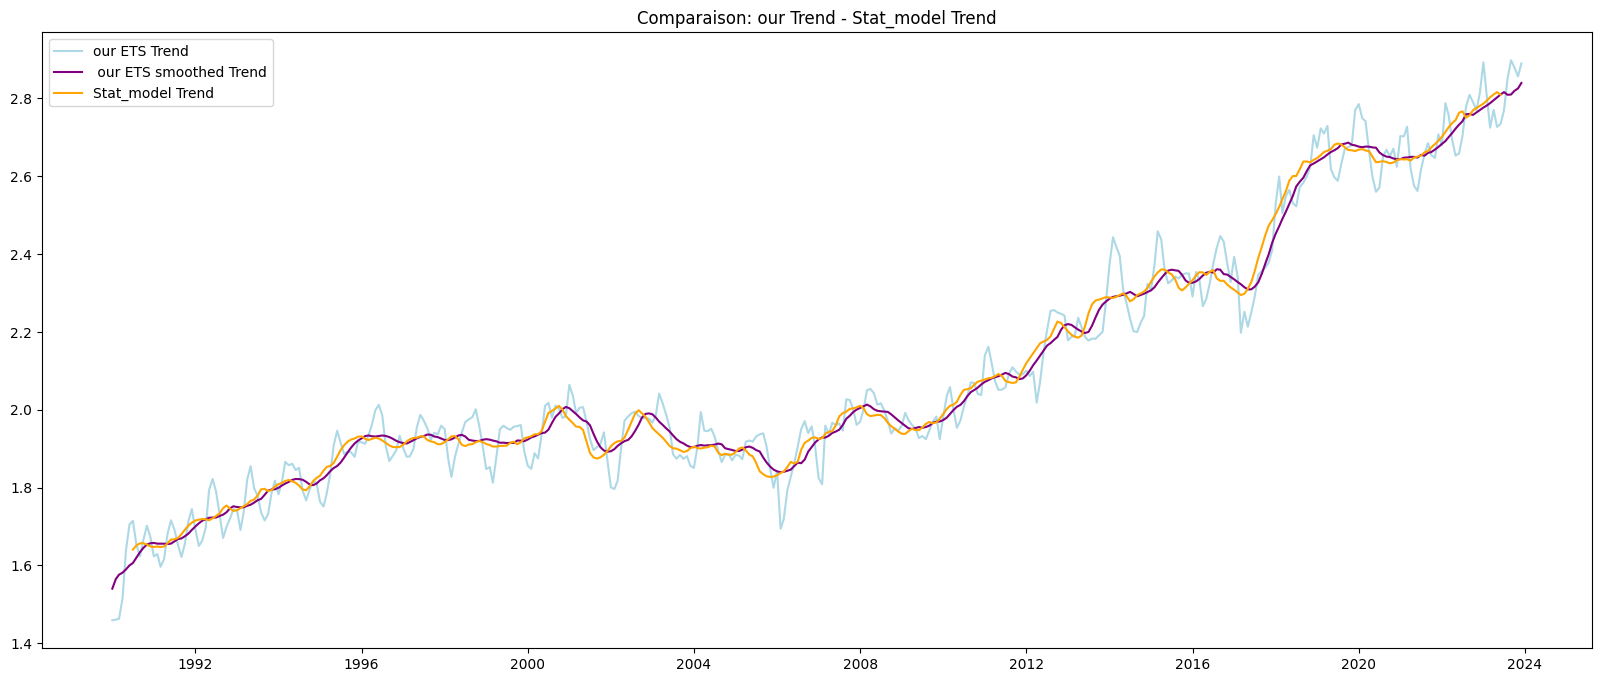

In [168]:
holt_model2 = Holt(endog=time_series_data,
                  exponential=False,
                  damped_trend=True,
                  ).fit(optimized=True, smoothing_level=0.1, smoothing_slope=0.1)

fitted_values2 = holt_model2.fittedvalues
smoothed_trend2 = fitted_values.rolling(window=12, min_periods=1, center=True).mean()  

plt.figure(figsize=(20, 8))

plt.plot(data['Date'], data['trend'], label='our ETS Trend', color='lightblue')
plt.plot(data['Date'], smoothed_trend2, label=' our ETS smoothed Trend', color="purple")
plt.plot(data['Date'], data['Stat model trend'], label='Stat_model Trend', color='orange')
plt.legend()
plt.title('Comparaison: our Trend - Stat_model Trend')
plt.show()


So we can deduce that the difference between the trend modeling from statsmodel and our ETS decomposition, is a matter a smoothing parameter !

Let's continue with our initial trend (not further smoothed) to have more accurate forecast.

/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/517881925.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Stat model season"] = additive_decomposition.seasonal


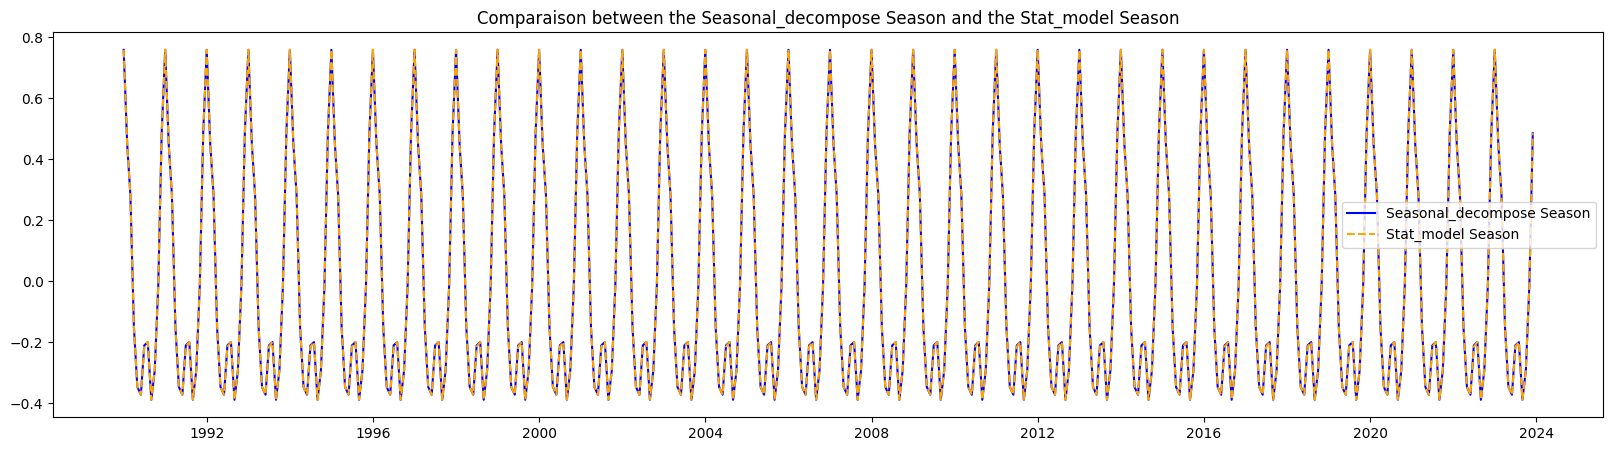

In [132]:
data["Stat model season"] = additive_decomposition.seasonal

plt.figure(figsize=(20, 5))

# Original data
plt.plot(data['Date'], data['Seasonal Index'], label='Seasonal_decompose Season', color='blue')
plt.plot(data['Date'], data['Stat model season'], label='Stat_model Season', color='orange', linestyle='--')
plt.legend()
plt.title('Comparaison between the Seasonal_decompose Season and the Stat_model Season')
plt.show()


/var/folders/4x/7dllvzl97q73lyx0wmq_91l00000gn/T/ipykernel_55173/62608142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Stat model residual"] = additive_decomposition.resid


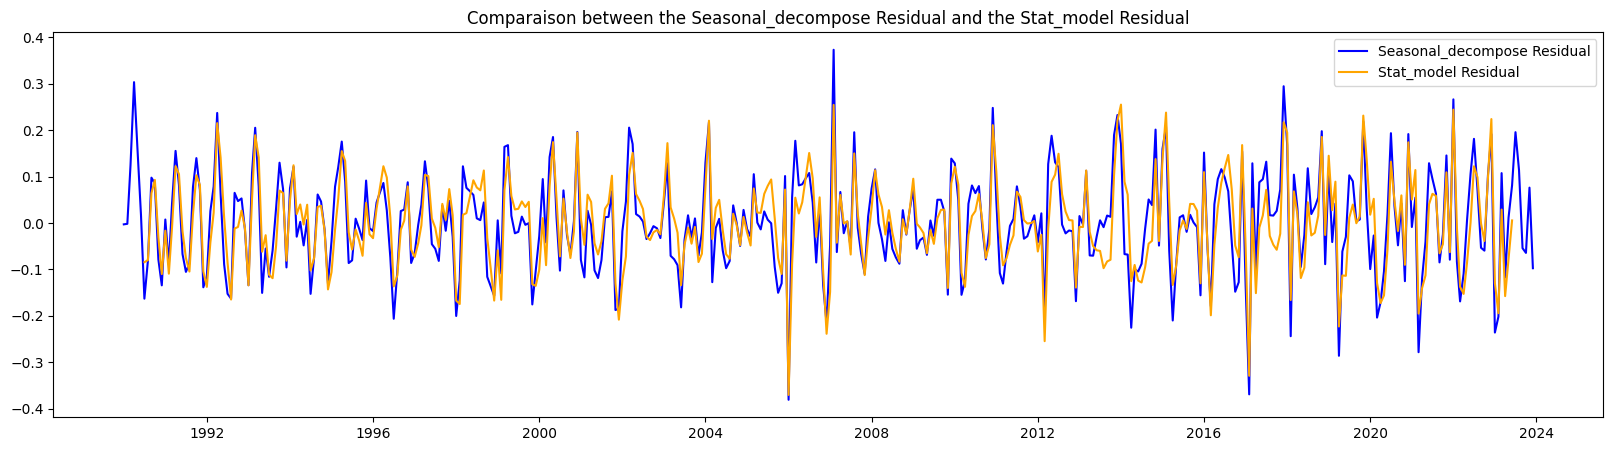

In [133]:
data["Stat model residual"] = additive_decomposition.resid

plt.figure(figsize=(20, 5))

# Original data
plt.plot(data['Date'], data['residual'], label='Seasonal_decompose Residual', color='blue')
plt.plot(data['Date'], data['Stat model residual'], label='Stat_model Residual', color='orange')
plt.legend()
plt.title('Comparaison between the Seasonal_decompose Residual and the Stat_model Residual')
plt.show()


Here, the differences are mostly coming from the fact that there were already discrepancies between the trend models (see 3-4 cells above this one)

## IV) Forecasting

### Trend forecast 

The trend forecast is generated using the Holt model, which effectively captures the long-term direction of the data. 

By applying the formula `holt_model.forecast(12)`, we can predict the next 12 time periods based on the identified trend. 

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


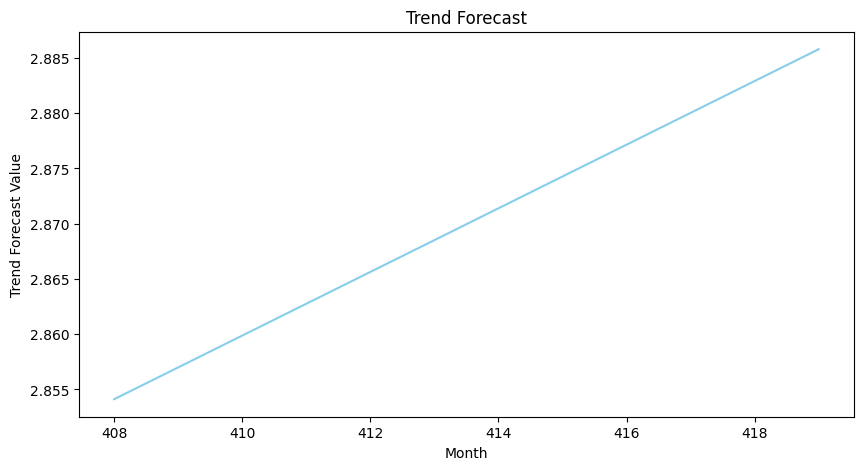

In [114]:
trend_forecast = holt_model.forecast(12)

plt.figure(figsize=(10, 5))
plt.plot(trend_forecast.index, trend_forecast.values, color='skyblue')
plt.title('Trend Forecast')
plt.xlabel('Month')
plt.ylabel('Trend Forecast Value')
plt.show()

### Seasonal forecast 
To create a seasonal forecast, we will utilize the seasonal components identified earlier and copy them to forecast the next seasonal values. 

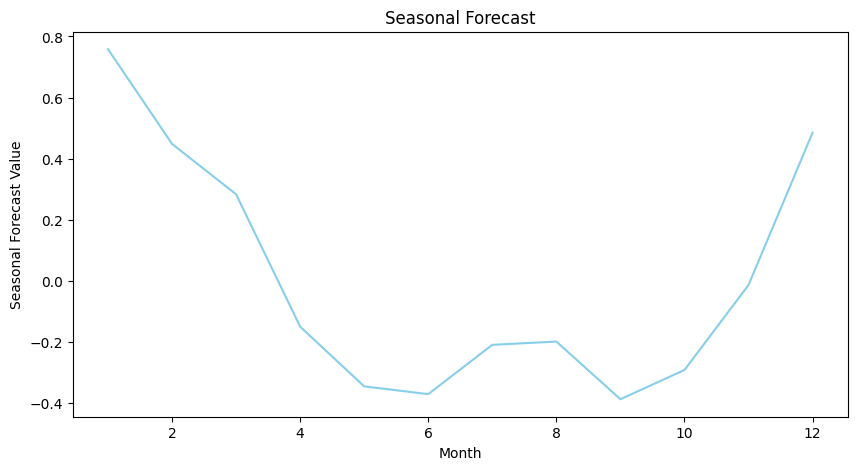

In [115]:
#renaming a former variable to make things more clear:
season_forecast = correction 

plt.figure(figsize=(10, 5))
plt.plot(season_forecast.index, season_forecast.values, color='skyblue')
plt.title('Seasonal Forecast')
plt.xlabel('Month')
plt.ylabel('Seasonal Forecast Value')
plt.show()

### Residual forecast 

Here are the steps involved in this process:

- Augmented Dickey Fuller test (ADF test)

Before fitting a model to the residuals, it is important to check if they are stationary. Stationarity means that the statistical properties of the residuals, like mean and variance, do not change over time. Techniques such as the Augmented Dickey-Fuller (ADF) test can be employed to check for stationarity.

In [116]:
from arch.unitroot import ADF

adf = ADF(data['residual'], lags=0)
print(adf.summary().as_text())

   Augmented Dickey-Fuller Results   
Test Statistic                -16.458
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.45 (1%), -2.87 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Interpretation
Since the p-value is significantly less than 0.05, we reject the null hypothesis, indicating that the process is weakly stationary. The test statistic of -16.458 is much lower than the critical values at all significance levels (1%, 5%, and 10%). This strong result suggests that the time series does not contain a unit root, implying that it is not stationary.


Given the lack of stationarity observed in the original residuals, we may proceed with fitting an ARIMA model to capture any potential autocorrelation and account for the dynamics present in the data. 

This model will help in forecasting future values by utilizing both the autoregressive and moving average components, addressing the short-term fluctuations effectively.

- ARIMA (p,i,q)

    Autoregressive (AR) Component:
    - Represents the relationship between an observation and a number of lagged observations (previous values).
    - Defined by the parameter p, which indicates the number of lagged terms to include.

    Integrated (I) Component:
    - Refers to the differencing of raw observations to make the time series stationary.
    - Defined by the parameter d, which indicates the number of times the data should be differenced.

    Moving Average (MA) Component:
    - Represents the relationship between an observation and a residual error from a moving average model applied to lagged observations.
    - Defined by the parameter q, which indicates the number of lagged forecast errors to include.

In [117]:
import statsmodels.api as sm
import statsmodels
plt.rcParams["figure.figsize"] = (7, 3)

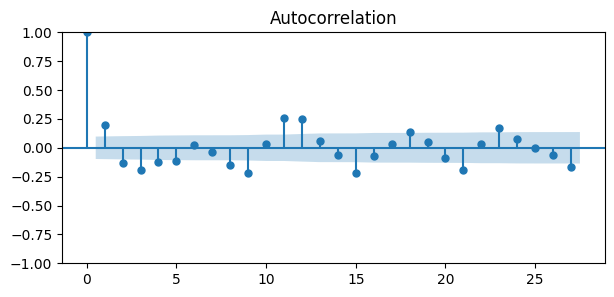

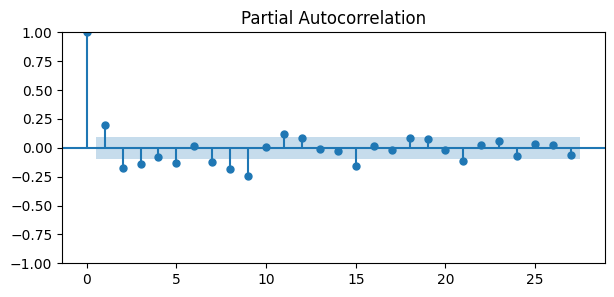

In [118]:
statsmodels.graphics.tsaplots.plot_acf(
    x=data["residual"]
)
statsmodels.graphics.tsaplots.plot_pacf(
    x=data["residual"]
)
plt.show()

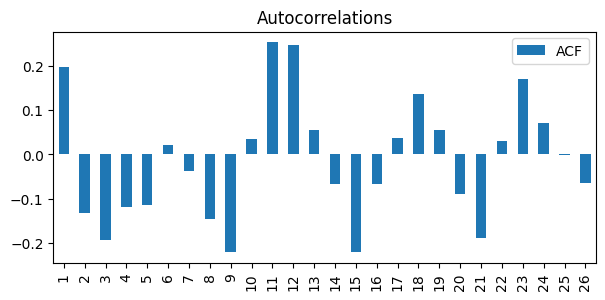

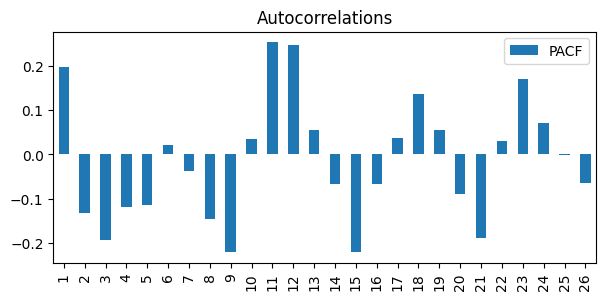

In [119]:
acf = pd.DataFrame(sm.tsa.stattools.acf(data["residual"],), columns=["ACF"])
fig = acf[1:].plot(kind="bar", title="Autocorrelations")

pacf = pd.DataFrame(sm.tsa.stattools.acf(data["residual"],), columns=["PACF"])
fig = pacf[1:].plot(kind="bar", title="Autocorrelations")

In [120]:
acf[1:6], pacf[1:4]

(        ACF
 1  0.197002
 2 -0.131961
 3 -0.194108
 4 -0.119871
 5 -0.114687,
        PACF
 1  0.197002
 2 -0.131961
 3 -0.194108)

In [121]:
arima_model = ARIMA(data["residual"], order=(3, 1, 5)).fit()
print(arima_model.params)
residual_pred = arima_model.predict()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ar.L1    -1.138618
ar.L2    -1.061898
ar.L3    -0.893393
ma.L1     0.406211
ma.L2    -0.038694
ma.L3    -0.168165
ma.L4    -0.903209
ma.L5    -0.293760
sigma2    0.010789
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


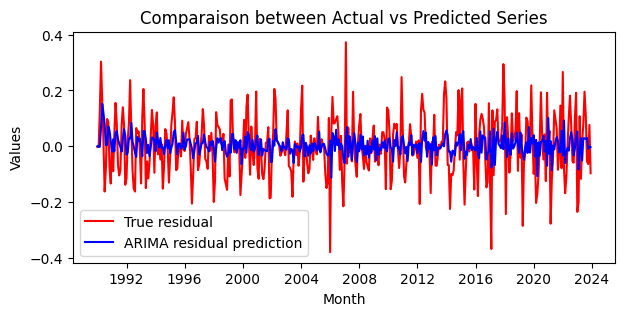

In [122]:
plt.plot(data['Date'], data['residual'], label='True residual', color='red')   
plt.plot(data['Date'], residual_pred, label='ARIMA residual prediction', color='blue') 

plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Comparaison between Actual vs Predicted Series')
plt.legend()
plt.show()

In [123]:
residual_forecast = arima_model.forecast(12)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


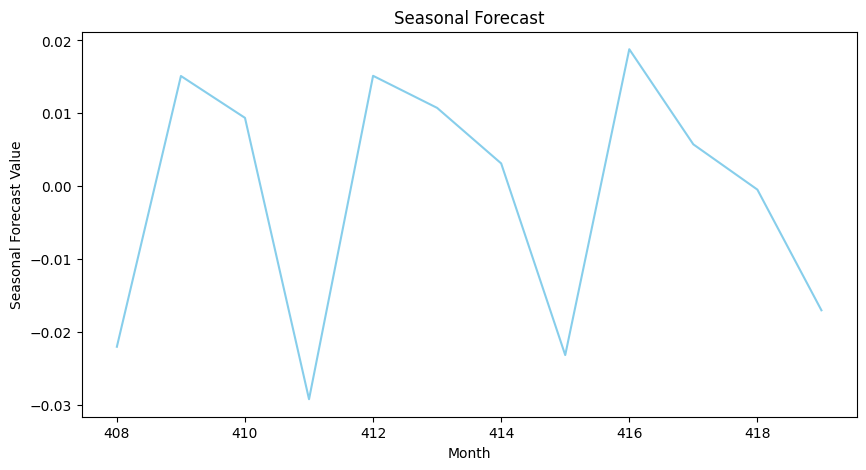

In [124]:
plt.figure(figsize=(10, 5))
plt.plot(residual_forecast.index, residual_forecast.values, color='skyblue')
plt.title('Seasonal Forecast')
plt.xlabel('Month')
plt.ylabel('Seasonal Forecast Value')
plt.show()

### Summing the forecasts

To forecast the time series, in this additive model, we can simply add the forecasts of the trend, season and error.


Let's reorganize the data to plot it:

In [126]:
forecast = data.iloc[:0,:].copy()

ind = np.linspace(1,12,12)

t = pd.Series(trend_forecast)
r = pd.Series(residual_forecast)
s = pd.Series(season_forecast)
t.index, r.index, s.index = ind, ind, ind

new_dates = pd.date_range(start=data["Date"].iloc[-1] + pd.offsets.MonthBegin(), periods=12, freq='MS')
forecast["Date"] = pd.Series(new_dates, index=ind)

forecast["Value"] = t + r + s

data_pred = filtered_df[(filtered_df['Date'] >= '2024-01-01')]
data_pred.index = [1, 2, 3, 4, 5, 6]
data_pred

,Value,Date
1,3.822250,2024-01-01
2,3.069708,2024-02-01
3,2.887406,2024-03-01
4,2.475477,2024-04-01
5,2.406148,2024-05-01
6,2.510376,2024-06-01


Let's observe our prediction along with a control sample that we kept to make validation:

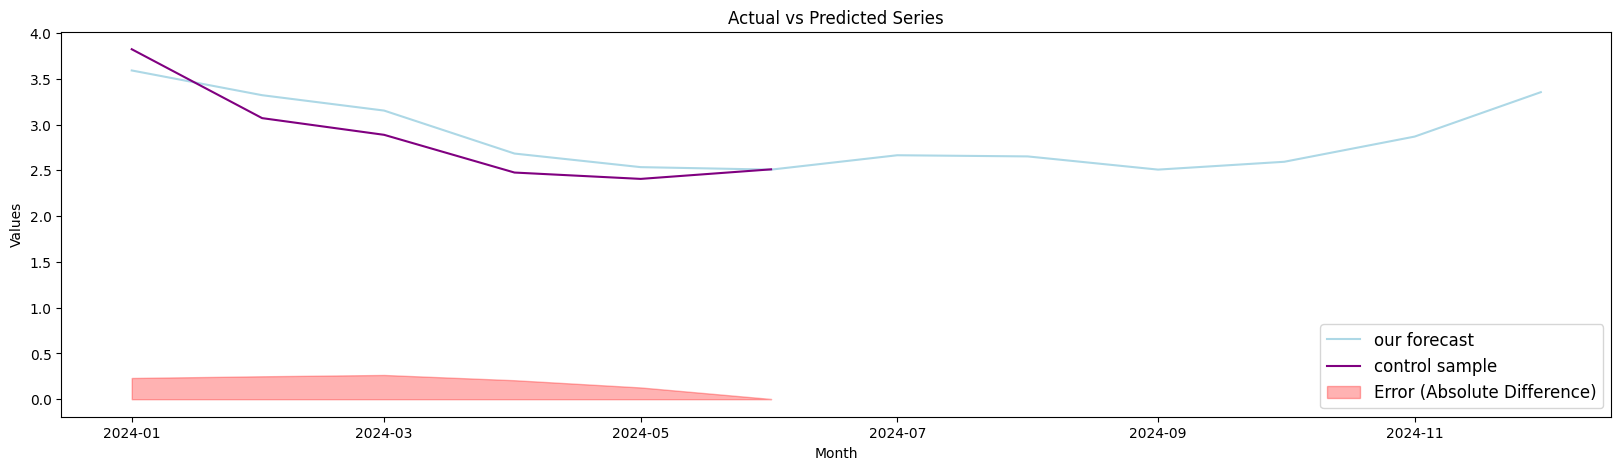

In [130]:
forecast["error"] = np.abs(forecast['Value'] - data_pred['Value'])

# Plot original, adjusted, trend, and error data
plt.figure(figsize=(20, 5))

# Pred
plt.plot(forecast['Date'], forecast['Value'], label='our forecast', color='lightblue')
# Temoin
plt.plot(data_pred['Date'], data_pred['Value'], label='control sample', color='purple')
#Error
#plt.plot(forecast['Date'], forecast["error"], label='error', color='red')
plt.fill_between(forecast['Date'], 0, forecast["error"], color='red', alpha=0.3, label='Error (Absolute Difference)')

plt.xlabel('Month')
plt.ylabel('Values')
plt.title('Actual vs Predicted Series')
plt.legend(fontsize=12, loc='lower right') 
plt.show()

Now, let's juxtapose the original data, the control sample and our prediction to observe the global result or our ETS decomposition

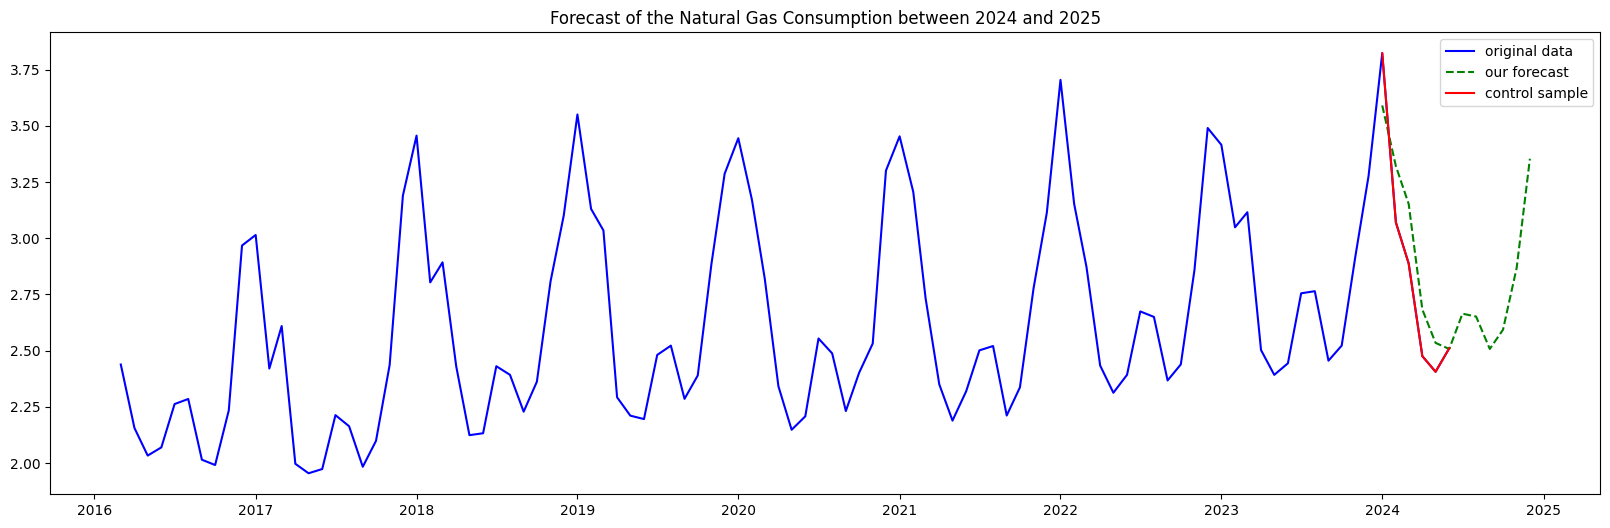

In [131]:
plt.figure(figsize=(20, 6))
plt.plot(filtered_df['Date'][-100:], filtered_df['Value'][-100:], label='original data', color='blue')
plt.plot(forecast['Date'], forecast['Value'], label='our forecast', color='green', linestyle="--")
# control
plt.plot(data_pred['Date'], data_pred['Value'], label='control sample', color='red')

plt.title('Forecast of the Natural Gas Consumption between 2024 and 2025')
plt.legend() 
plt.show()